# Notebook procesamiento de audio

## Inicialización FPGA

In [1]:
# Librería PYNQ
from pynq import Overlay, allocate
# Estructuras de datos y gráficos
import numpy as np
import matplotlib.pyplot as plt
# Librería MIDI
from mido import Message, MidiFile, MidiTrack, second2tick
# Librería lectura y creación de archivos de audio
from scipy.io import wavfile

In [30]:
# Controladores bloques de procesamiento
%run FFT_DMA_Driver.ipynb
%run Audio_DMA_Driver.ipynb

In [31]:
# Cargar Overlay FFT 
# (Exportar bitstream y hardware en Vivado)
ol = Overlay('/home/xilinx/pynq/overlays/fft/disenofinal.bit')

In [4]:
# Que bloques tiene
ol?

In [32]:
# Inicializar DMAs, para enviar y recibir datos y configuración
fft = ol.fft_block
audio = ol.audio_block

## Carga de archivo de audio

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Sample Rate: 44100


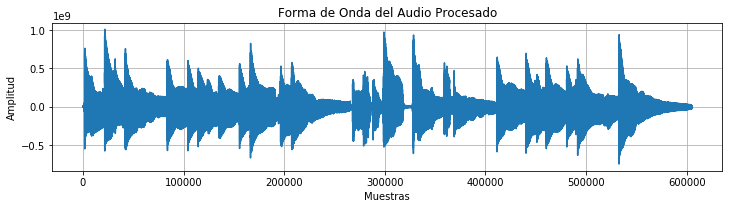

In [46]:
# Cargar archivo de audio
SAMPLE_RATE, audio_data = wavfile.read("eldiablofloat.wav")
print("Sample Rate: " + str(SAMPLE_RATE))

# Convertir a mono si es necesario
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)
    
# Normalizar el audio para la visualización
#audio_data = audio_data / np.max(np.abs(audio_data))

# Asegurarse de que el audio esté en formato int32
audio_data = (audio_data * np.iinfo(np.int32).max).astype(np.int32)

In [ ]:
# Gráfica forma de onda
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_data)
plt.title("Forma de Onda del Audio Procesado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

## Configuración  e inicialización

In [47]:
# Inicialización parámetros y funciones
BLOCK_SIZE = 1024
audio.configure(BLOCK_SIZE)
audio.gain_set_gain(8)
audio.rect_set_enable(1)
audio.clip_set_threshold(0.3)

# Buffer de entrada para DMA
input_buffer_audio = allocate(shape=(BLOCK_SIZE,), dtype=np.int32)

# Función para recibir el Audio Procesado
def apply_effects(input_data):
    np.copyto(input_buffer_audio, input_data.astype(np.int32))
    return audio.apply_effects(input_buffer_audio)

## Procesamiento audio con efectos FPGA

In [48]:
%%time
# Procesar el audio
audio_results = []

block = np.zeros(BLOCK_SIZE, dtype=np.int32)

# Dividir el audio en bloques y aplicar efectos
for start in range(0, len(audio_data), BLOCK_SIZE):
    end = start + BLOCK_SIZE
    if end > len(audio_data):    
        block[:len(audio_data) - start] = audio_data[start:]
    else:
        block = audio_data[start:end].astype(np.int32)
    
    # Aplicar efectos (por ejemplo, ganancia) a los datos
    res_audio = apply_effects(block)
    
    # Imprimir los pares block - res_audio
    #print(f"Pares block - res_audio para el bloque {start//BLOCK_SIZE}:")
    #for idx, (original, processed) in enumerate(zip(block[:20], res_audio[:20])):
    #    print(f"Índice: {idx}, Original: {original}, Procesado: {processed}")
    
    audio_results.append(np.copy(res_audio))

CPU times: user 382 ms, sys: 0 ns, total: 382 ms
Wall time: 383 ms


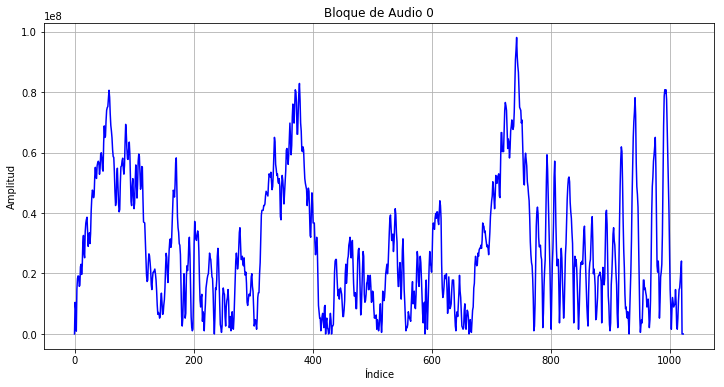

In [49]:
# Graficar un bloque de audio
block_to_plot = audio_results[0]

plt.figure(figsize=(12, 6))
plt.plot(block_to_plot, color='blue')
plt.xlabel('Índice')
plt.ylabel('Amplitud')
plt.title('Bloque de Audio 0')
plt.grid(True)
plt.show()

## Reconvertir bloques procesados en archivo de audio

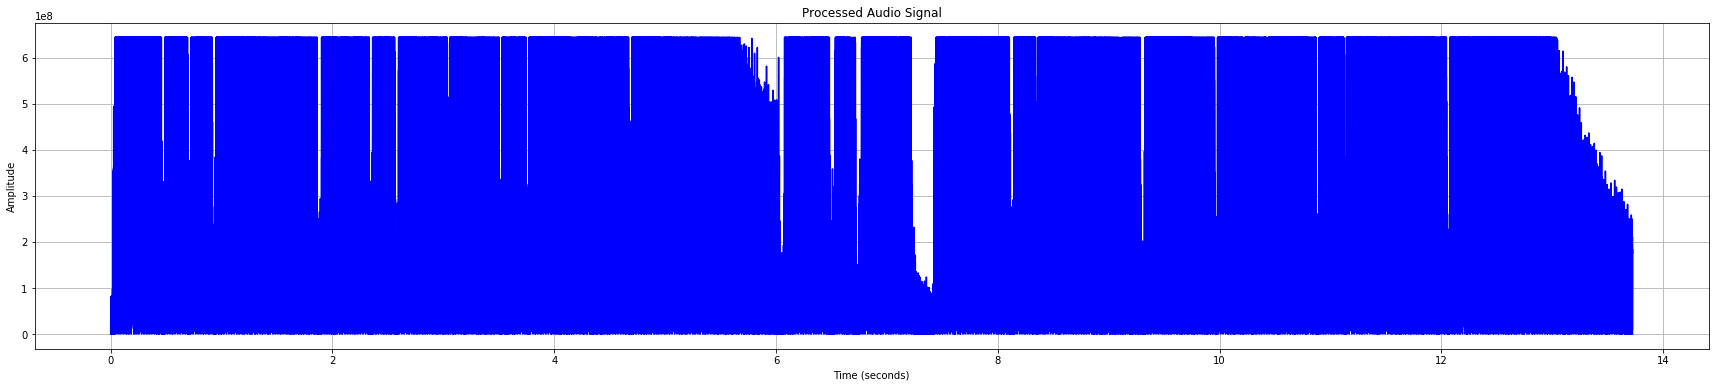

In [51]:
# Concatenar todos los bloques de audio procesados en una sola señal continua
processed_audio_plot = np.concatenate(audio_results)

# Crear un array de tiempo correspondiente
total_samples = len(processed_audio_plot)
time_array = np.arange(total_samples) / SAMPLE_RATE

# Graficar la señal procesada
plt.figure(figsize=(30, 6))
plt.plot(time_array, processed_audio_plot, color='b')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Processed Audio Signal')
plt.grid(True)
plt.show()


In [50]:
# Supongamos que audio_results es una lista de PynqBuffer obtenidos del bucle de procesamiento
# Convertir PynqBuffer a un array numpy
processed_audio = np.concatenate([np.asarray(buffer) for buffer in audio_results])

# Normalizar la señal
#max_value = np.max(np.abs(processed_audio))
#if max_value > 0:
#    processed_audio = processed_audio / max_value * 32767

# Guardar el archivo WAV
output_filename = 'output_audio.wav'
wavfile.write(output_filename, SAMPLE_RATE, processed_audio)

print(f"Archivo WAV creado y guardado como '{output_filename}'.")


Archivo WAV creado y guardado como 'output_audio.wav'.
